In [17]:
# plot imports
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage.measure import EllipseModel
from lc_tda.plot import rcparams, format_axis, format_axis_im

# sklearn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

# other imports
import glob
import pickle
import numpy as np

# format figures
rcparams(1)

# define color cycle
COLOR = ['#515151', '#df5048', '#3370d8', '#5baa71',
         '#a87bd8', '#c49b33', '#5bc8ca', '#76504f',
         '#8e8c2b', '#ea6f2d', '#7099c8', '#80b537']

# descriptor orders:
# 0: AR, 1: BL, 2: EC, 3: FD, 4: LA

# color orders:
# 0: A*, 1: B*, 2: blue, 3: gray, 4: green, 5: L*, 6: red


### 1. Dataset PCA

Corresponding to Figure 7.


In [29]:
with open('../data/so2rh/rh_tda.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)

x = x[:, :, 2, 3]  # grayscale EC
ss = StandardScaler()  # normalization
x = ss.fit_transform(x)
pca = PCA(n_components=2, whiten=True, random_state=0)  # PCA
x = pca.fit_transform(x)


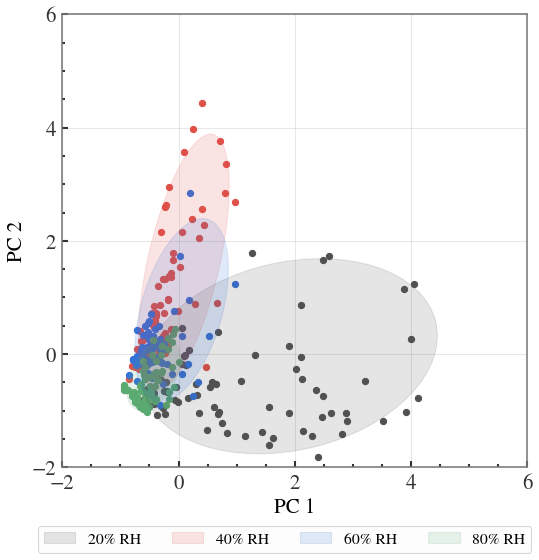

In [30]:
# plot RH PCA
labels = ['20% RH', '40% RH', '60% RH', '80% RH']
fig, ax = plt.subplots()
for i, u in enumerate(np.unique(y)):
    idx = np.where(y == u)[0]
    a_points = x[idx]
    ax.scatter(a_points[:, 0], a_points[:, 1])
    ell = EllipseModel()
    ell.estimate(a_points)
    xc, yc, a, b, theta = ell.params
    ell_patch = Ellipse((xc, yc), 2.5*a, 2.5*b, theta*180/np.pi,
                        edgecolor=COLOR[i], facecolor=COLOR[i], alpha=0.15)
    ax.add_patch(ell_patch)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_xlim([-2, 6])
ax.set_ylim([-2, 6])
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.92, -0.03),
           ncol=len(labels), bbox_transform=fig.transFigure,)

format_axis(ax)

plt.savefig('../image/case_study_so2_rh/pca_rh.png', dpi=300,
            bbox_inches='tight', transparent=True)


In [31]:
with open('../data/so2rh/so2_tda.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)
x = x[:, :, 2, 3]
ss = StandardScaler()
x = ss.fit_transform(x)
pca = PCA(n_components=2, whiten=True, random_state=0)
x = pca.fit_transform(x)


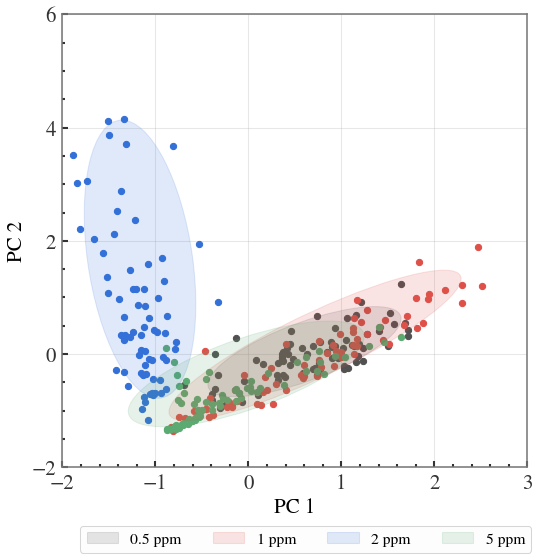

In [32]:
# plot SO2 PCA
labels = ['0.5 ppm', '1 ppm', '2 ppm', '5 ppm']
fig, ax = plt.subplots()
for i, u in enumerate(np.unique(y)):
    idx = np.where(y == u)[0]
    a_points = x[idx]
    ax.scatter(a_points[:, 0], a_points[:, 1])
    ell = EllipseModel()
    ell.estimate(a_points)
    xc, yc, a, b, theta = ell.params
    ell_patch = Ellipse((xc, yc), 2.5*a, 2.5*b, theta*180/np.pi,
                        edgecolor=COLOR[i], facecolor=COLOR[i], alpha=0.15)
    ax.add_patch(ell_patch)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_xlim([-2, 3])
ax.set_ylim([-2, 6])
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.92, -0.03),
           ncol=len(labels), bbox_transform=fig.transFigure,)

format_axis(ax)

plt.savefig('../image/case_study_so2_rh/pca_so2.png', dpi=300,
            bbox_inches='tight', transparent=True)


### 2. Dataset Topological Descriptor Curves

Corresponding to Figure 7.


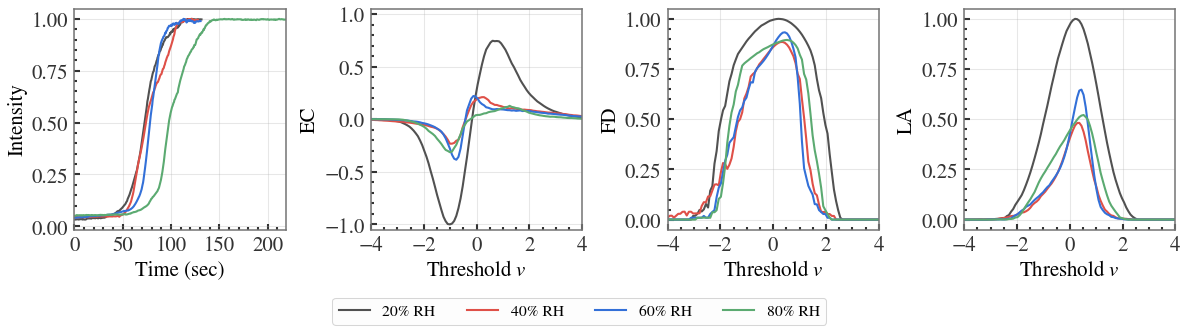

In [18]:
# plot average intensity and topological descriptor curves
with open('../data/so2rh/brightness_rh.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)

with open('../data/so2rh/rh_tda.pickle', 'rb') as handle:
    xx = pickle.load(handle)

y_unique = np.unique(y)

fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
times = []
for i, y_ in enumerate(y_unique):
    ind = np.where(y == y_)[0]
    x_ = [x[i] for i in ind]

    time_max = np.max([len(x_[i]) for i in range(len(x_))])
    time = np.arange(time_max) * 0.5
    times.append(time.max())

    x_same_time = []
    for j in range(len(x_)):
        xst_ = np.zeros(time_max)
        xst_[:len(x_[j])] = x_[j]
        xst_[len(x_[j]):] = x_[j][-1]
        x_same_time.append(xst_)
    x_ = np.array(x_same_time)

    x_ -= x_.min()
    x_ /= x_.max()

    m_ = x_.mean(axis=0)
    m_ /= m_.max()

    ax[0].plot(time, m_, label=f'${y_*100:0.0f}\%$ RH')

ax[0].set_xlim([0, np.max(times)])
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Intensity')
format_axis(ax[0])


threshold = np.linspace(-4, 4, 100)
names = ['EC', 'FD', 'LA']
ylims = [[-1.05, 1.05], [-0.05, 1.05], [-0.05, 1.05]]
for j, name in enumerate(names):
    vmax = []
    for i, y_ in enumerate(y_unique):
        ind = np.where(y == y_)[0]
        x_ = xx[ind][..., j+2, 3].mean(axis=0)
        vmax.append(np.abs(x_).max())

    vmax = np.max(vmax)
    for i, y_ in enumerate(y_unique):
        ind = np.where(y == y_)[0]
        x_ = xx[ind][..., j+2, 3].mean(axis=0)
        ax[j+1].plot(threshold, x_/vmax, label=f'{y_*100:0.0f}% RH')

    ax[j+1].set_xlim([-4, 4])
    ax[j+1].set_ylim(ylims[j])

    ax[j+1].set_xlabel('Threshold $v$')
    ax[j+1].set_ylabel(name)
    format_axis(ax[j+1])

labels = ['20% RH', '40% RH', '60% RH', '80% RH']
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.7, -0.13),
           ncol=len(labels), bbox_transform=fig.transFigure,)

plt.tight_layout()

plt.savefig('../image/case_study_so2_rh/avg_curves_rh.png', dpi=300,
            bbox_inches='tight', transparent=True)


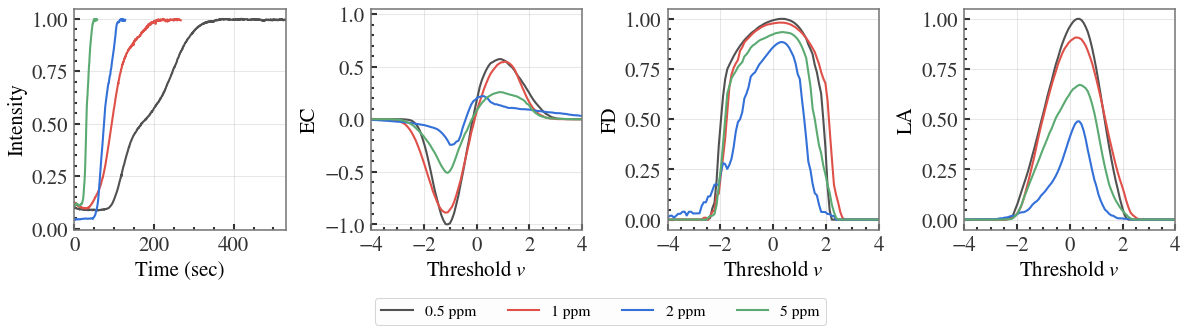

In [44]:
# plot average intensity and topological descriptor curves
with open(f'../data/so2rh/brightness_rh.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)

ind = np.where(y == 0.4)[0]
x40 = [x[i] for i in ind]

with open('../data/so2rh/brightness_so2.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)

x += x40

ratio = 134.54166666666666
ratio2 = 1.9682193788206135

with open('../data/so2rh/so2_tda.pickle', 'rb') as handle:
    xx = pickle.load(handle)

y = np.concatenate([y, np.ones(72)*2])

y_unique = np.unique(y)

fig, ax = plt.subplots(figsize=(16, 4), ncols=4)
times = []
for i, y_ in enumerate(y_unique):
    ind = np.where(y == y_)[0]
    x_ = [x[i] for i in ind]

    time_max = np.max([len(x_[i]) for i in range(len(x_))])
    time = np.arange(time_max) * 0.5
    times.append(time.max())

    x_same_time = []
    for j in range(len(x_)):
        xst_ = np.zeros(time_max)
        xst_[:len(x_[j])] = x_[j]
        xst_[len(x_[j]):] = x_[j][-1]
        x_same_time.append(xst_)
    x_ = np.array(x_same_time)

    x_ -= x_.min()
    x_ /= x_.max()

    m_ = x_.mean(axis=0)
    m_ /= m_.max()

    ax[0].plot(time, m_, label=f'${y_*100:0.0f}\%$ RH')

ax[0].set_xlim([0, np.max(times)])
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Intensity')
format_axis(ax[0])


threshold = np.linspace(-4, 4, 100)
names = ['EC', 'FD', 'LA']
ylims = [[-1.05, 1.05], [-0.05, 1.05], [-0.05, 1.05]]
for j, name in enumerate(names):
    vmax = []
    for i, y_ in enumerate(y_unique):
        ind = np.where(y == y_)[0]
        x_ = xx[ind][..., j+2, 3].mean(axis=0) * (ratio/ratio2)
        vmax.append(np.abs(x_).max())

    vmax = np.max(vmax)
    for i, y_ in enumerate(y_unique):
        ind = np.where(y == y_)[0]
        x_ = xx[ind][..., j+2, 3].mean(axis=0) * (ratio/ratio2)
        ax[j+1].plot(threshold, x_/vmax, label=f'{y_*100:0.0f}% RH')

    ax[j+1].set_xlim([-4, 4])
    ax[j+1].set_ylim(ylims[j])

    ax[j+1].set_xlabel('Threshold $v$')
    ax[j+1].set_ylabel(name)
    format_axis(ax[j+1])

labels = ['0.5 ppm', '1 ppm', '2 ppm', '5 ppm']
fig.legend(labels, loc='lower right', bbox_to_anchor=(0.7, -0.13),
           ncol=len(labels), bbox_transform=fig.transFigure,)

plt.tight_layout()

plt.savefig('../image/case_study_so2_rh/avg_curves_so2.png', dpi=300,
            bbox_inches='tight', transparent=True)


### 3. Prediction Results

Corresponding to Figure 8.


In [61]:
def result(name='rh', color='combined', desp='*', pca='25'):
    """A function to output results.

    Args:
        name (str, optional): 'rh' or 'so2'. Defaults to 'rh'.
        color (str, optional): color channel. Defaults to 'combined'.
        desp (str, optional): topological descriptors. Defaults to '*'.
        pca (str, optional): pca ratio. Defaults to '25'.

    Returns:
        tuple: accuracy, rmse
    """
    file = sorted(glob.glob(
        f'../result/tda/{name}_{color}_{desp}_{pca}.pickle'))
    yc, yr, time = [], [], []

    for file_ in file:
        with open(file_, 'rb') as handle:
            yc_ = pickle.load(handle)
            yr_ = pickle.load(handle)
            time_ = pickle.load(handle)
        yc.append(yc_)
        yr.append(yr_)
        time.append(time_)

    yc = np.array(yc)
    yr = np.array(yr)
    time = np.array(time)

    acc = np.array([accuracy_score(yc[i, 0], yc[i, 1])
                   for i in range(len(file))])
    rmse = np.array([mean_squared_error(yr[i, 0], yr[i, 1])
                    ** 0.5 for i in range(len(file))])

    if color == '*':
        acc = np.array([accuracy_score(yc[i, 0], yc[i, 1]) for i in range(len(file))])[
            [6, 7, 5, 3, 2, 0, 1, 4]]  # color idx
        rmse = np.array([mean_squared_error(yr[i, 0], yr[i, 1]) **
                        0.5 for i in range(len(file))])[[6, 7, 5, 3, 2, 0, 1, 4]]
    return acc, rmse


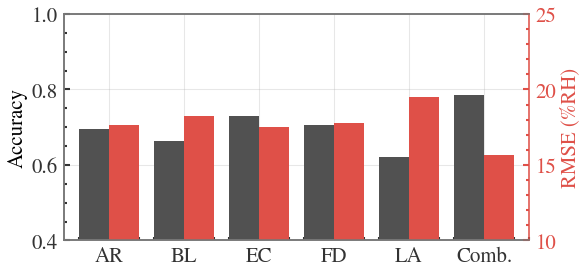

In [62]:
# RH descriptors
xx = np.arange(6)
acc_rh, rmse_rh = result(name='rh', color='gray', pca=100)
fig, ax = plt.subplots(figsize=(8, 4))
ax1 = ax.twinx()
ax.bar(xx-0.2, acc_rh, color=COLOR[0], width=0.4)
ax1.bar(xx+0.2, rmse_rh*100, color=COLOR[1], width=0.4)

ax.set_ylabel('Accuracy')
ax.set_xlim([-0.6, 5.6])
ax1.set_ylabel('RMSE (%RH)')

ax.set_ylim([0.4, 1.0])
ax1.set_ylim([10.0, 25.0])

ax.grid(True)
ax1.grid()
idx = np.argmax(acc_rh)
idx2 = np.argmin(rmse_rh)
format_axis(ax)
format_axis(ax1)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(COLOR[1])
ax1.tick_params(axis='y', which='both', colors=COLOR[1])
ax1.yaxis.label.set_color(COLOR[1])
ax.set_xticks(xx)
ax.set_xticklabels(['AR', 'BL', 'EC', 'FD', 'LA', 'Comb.'])

plt.savefig('../image/case_study_so2_rh/rh_desp.png', dpi=300,
            bbox_inches='tight', transparent=True)


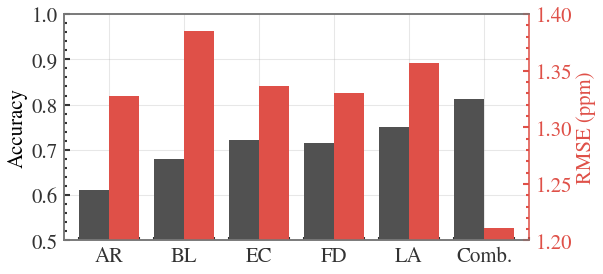

In [59]:
# SO2 Descriptor

acc_so2, rmse_so2 = result(name='so2', color='gray', pca=100)

xx = np.arange(6)

fig, ax = plt.subplots(figsize=(8, 4))
ax1 = ax.twinx()
ax.bar(xx-0.2, acc_so2, color=COLOR[0], width=0.4)
ax1.bar(xx+0.2, rmse_so2, color=COLOR[1], width=0.4)

ax.set_ylabel('Accuracy')
ax.set_xlim([-0.6, 5.6])
ax.set_ylim([0.5, 1.0])


ax1.set_ylabel('RMSE (ppm)')
ax1.set_ylim([1.2, 1.4])

ax.grid(True)
ax1.grid()
format_axis(ax)
format_axis(ax1)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(COLOR[1])
ax1.tick_params(axis='y', which='both', colors=COLOR[1])
ax1.yaxis.label.set_color(COLOR[1])
ax.set_xticks(xx)
ax.set_xticklabels(['AR', 'BL', 'EC', 'FD', 'LA', 'Comb.'])

plt.savefig('../image/case_study_so2_rh/so2_desp.png', dpi=300,
            bbox_inches='tight', transparent=True)


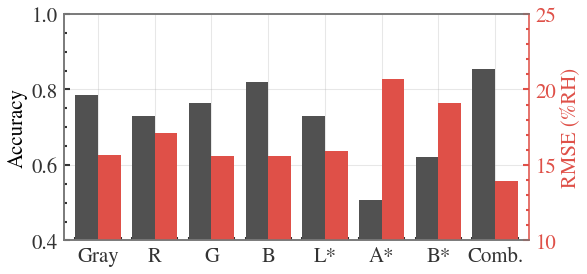

In [63]:
# RH Color Channels

acc_rh, rmse_rh = result(name='rh', color='*', desp='combined', pca=100)
xx = np.arange(8)

fig, ax = plt.subplots(figsize=(8, 4))
ax1 = ax.twinx()
ax.bar(xx-0.2, acc_rh, color=COLOR[0], width=0.4)
ax1.bar(xx+0.2, rmse_rh*100, color=COLOR[1], width=0.4)

ax.set_ylabel('Accuracy')
ax.set_xlim([-0.6, 7.6])
ax1.set_ylabel('RMSE (%RH)')
ax.set_ylim([0.4, 1.0])
ax1.set_ylim([10.0, 25.0])
idx = np.argmax(acc_rh)
idx2 = np.argmin(rmse_rh)

ax.grid(True)
ax1.grid()
format_axis(ax)
format_axis(ax1)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(COLOR[1])
ax1.tick_params(axis='y', which='both', colors=COLOR[1])
ax1.yaxis.label.set_color(COLOR[1])
ax.set_xticks(xx)
ax.set_xticklabels(['Gray', 'R', 'G', 'B', 'L*', 'A*', 'B*', 'Comb.'])

plt.savefig('../image/case_study_so2_rh/rh_color.png', dpi=300,
            bbox_inches='tight', transparent=True)


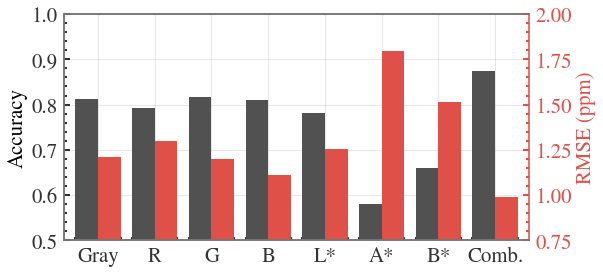

In [64]:
acc_so2, rmse_so2 = result(name='so2', color='*', desp='combined', pca=100)
xx = np.arange(8)

fig, ax = plt.subplots(figsize=(8, 4))
ax1 = ax.twinx()
ax.bar(xx-0.2, acc_so2, color=COLOR[0], width=0.4)
ax1.bar(xx+0.2, rmse_so2, color=COLOR[1], width=0.4)

ax.set_ylabel('Accuracy')
ax.set_xlim([-0.6, 7.6])
ax.set_ylim([0.5, 1.0])

ax1.set_ylabel('RMSE (ppm)')
ax1.set_ylim([0.75, 2.0])

ax.grid(True)
ax1.grid()
format_axis(ax)
format_axis(ax1)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(COLOR[1])
ax1.tick_params(axis='y', which='both', colors=COLOR[1])
ax1.yaxis.label.set_color(COLOR[1])
ax.set_xticks(xx)
ax.set_xticklabels(['Gray', 'R', 'G', 'B', 'L*', 'A*', 'B*', 'Comb.'])

plt.savefig('../image/case_study_so2_rh/so2_color.png', dpi=300,
            bbox_inches='tight', transparent=True)


In [11]:
def tda_prediction(name='rh', pca=100):
    """TDA regression and classification predictions.

    Args:
        name (str, optional): 'rh' or 'so2'. Defaults to 'rh'.
        pca (int, optional): PCA ratio. Defaults to 100.

    Returns:
        tuple: classification, regression predictions and time.
    """

    file = sorted(glob.glob(
        f'../result/tda/{name}_combined_combined_{pca}.pickle'))
    yc, yr, time = [], [], []
    for file_ in file:
        with open(file_, 'rb') as handle:
            yc_ = pickle.load(handle)
            yr_ = pickle.load(handle)
            time_ = pickle.load(handle)
        yc.append(yc_)
        yr.append(yr_)
        time.append(time_)

    yc = np.array(yc).squeeze()
    yr = np.array(yr).squeeze()
    time = np.array(time).squeeze()
    return yc, yr, time


def cnn_prediction(name='rh', task='cls'):
    """CNN regression and classification predictions.

    Args:
        name (str, optional): 'rh' or 'so2'. Defaults to 'rh'.
        task (str, optional): 'cls' or 'reg'. Defaults to 'cls'.

    Returns:
        tuple: prediction, time
    """
    files = glob.glob(
        f'../result/cnn/{name}/test_*_{task}.pickle')
    y_test = []
    y_pred = []
    time = []
    for file in files:
        with open(file, 'rb') as handle:
            y_ = pickle.load(handle)
            y_pred_ = pickle.load(handle).squeeze()
            _ = pickle.load(handle)
            time_ = pickle.load(handle)
            if task == 'cls':
                y_ = np.argmax(y_, axis=1)
                y_pred_ = np.argmax(y_pred_, axis=1)
        y_test.append(y_)
        y_pred.append(y_pred_)
        time.append(time_)
    y_test = np.concatenate(y_test)
    y_pred = np.concatenate(y_pred)

    y = np.concatenate((y_test[None, ...], y_pred[None, ...]), axis=0)
    time = np.array(time)
    return y, time


In [12]:
yc_rh, yr_rh, time_rh = tda_prediction(name='rh')
yc_so2, yr_so2, time_so2 = tda_prediction(name='so2')
yc_cnn_rh, timec_cnn_rh = cnn_prediction(name='rh', task='cls')
yc_cnn_so2, timec_cnn_so2 = cnn_prediction(name='so2', task='cls')
yr_cnn_rh, timer_cnn_rh = cnn_prediction(name='rh', task='reg')
yr_cnn_so2, timer_cnn_so2 = cnn_prediction(name='so2', task='reg')


In [13]:
print(f'RH TDA Acc:  {accuracy_score(yc_rh[0], yc_rh[1]):0.4f}')
print(f'RH CNN Acc:  {accuracy_score(yc_cnn_rh[0], yc_cnn_rh[1]):0.4f}')
print(f'SO2 TDA Acc: {accuracy_score(yc_so2[0], yc_so2[1]):0.4f}')
print(f'So2 CNN Acc: {accuracy_score(yc_cnn_so2[0], yc_cnn_so2[1]):0.4f}')

print(f'RH TDA RMSE:  {mean_squared_error(yr_rh[0], yr_rh[1])**0.5:0.4f}')
print(
    f'RH CNN RMSE:  {mean_squared_error(yr_cnn_rh[0], yr_cnn_rh[1])**0.5:0.4f}')
print(f'SO2 TDA RMSE: {mean_squared_error(yr_so2[0], yr_so2[1])**0.5:0.4f}')
print(
    f'SO2 CNN RMSE: {mean_squared_error(yr_cnn_so2[0], yr_cnn_so2[1])**0.5:0.4f}')

# the time is for 1 fold, to consider 5 fold, times 5.
print(f'RH TDA Time:  {time_rh.mean():0.4f} + {time_rh.std():0.4f}')
print(
    f'RH CNN Time:  {np.concatenate([timer_cnn_rh, timec_cnn_rh]).mean():0.4f} + {np.concatenate([timer_cnn_rh, timec_cnn_rh]).std():0.4f}')
print(f'SO2 TDA Time: {time_so2.mean():0.4f} + {time_so2.std():0.4f}')
print(
    f'SO2 CNN Time: {np.concatenate([timer_cnn_so2, timec_cnn_so2]).mean():0.4f} + {np.concatenate([timer_cnn_so2, timec_cnn_so2]).std():0.4f}')


RH TDA Acc:  0.8542
RH CNN Acc:  0.8681
SO2 TDA Acc: 0.8750
So2 CNN Acc: 0.9514
RH TDA RMSE:  0.1396
RH CNN RMSE:  0.1261
SO2 TDA RMSE: 0.9895
SO2 CNN RMSE: 0.9450
RH TDA Time:  0.1453 + 0.0291
RH CNN Time:  37.9620 + 14.5080
SO2 TDA Time: 0.1600 + 0.0273
SO2 CNN Time: 23.6180 + 6.2273


### 4. Computational Time

Corresponding to Figure 8.


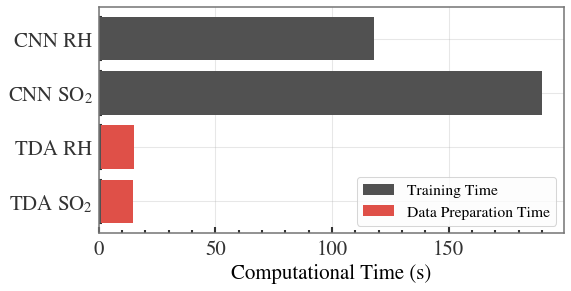

In [15]:

fig, ax = plt.subplots(figsize=(8, 4))  # consider 5-fold
ax.barh(range(2, 4), [37.96*5, 23.62*5], capsize=5,
        color=COLOR[0], label='Training Time')
ax.barh(range(2), [0.1453*5, 0.1600*5], capsize=5, color=COLOR[0])
ax.barh(range(2), [0.1453*5+13.2748, 0.1600*5+13.2748], left=[0.1453*5,
        0.1600*5], capsize=5, color=COLOR[1], label='Data Preparation Time')  # training + data preparation
ax.set_xlabel('Computational Time (s)')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['TDA SO$_2$', 'TDA RH', 'CNN SO$_2$', 'CNN RH'])

ax.legend()
format_axis(ax)

plt.savefig('../image/case_study_so2_rh/time.png', dpi=300,
            bbox_inches='tight', transparent=True)


### 5. Confusion Matrices

Corresponding to Figure 8.


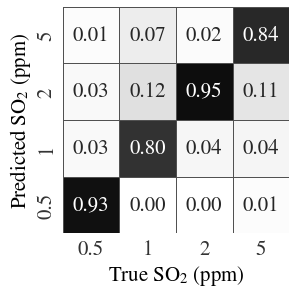

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))
conf = confusion_matrix(yc_so2[0], yc_so2[1], normalize='pred')

conf = np.flipud(conf)
name = ['0.5', '1', '2', '5']

sn.heatmap(conf, annot=True, cmap="gray_r", square=True, vmax=1, vmin=0, fmt='0.2f',
           linewidths=.5, linecolor=COLOR[0], annot_kws={'fontsize': 20}, cbar=False)

ax.set_xlabel('True SO$_2$ (ppm)')
ax.set_ylabel('Predicted SO$_2$ (ppm)')
format_axis_im(ax)
plt.xticks(np.arange(0.5, 4, 1), name, horizontalalignment='center')
plt.yticks(np.arange(3.5, -0.5, -1), name, verticalalignment='center')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/conf_tda_so2.png', dpi=300,
            bbox_inches='tight', transparent=True)


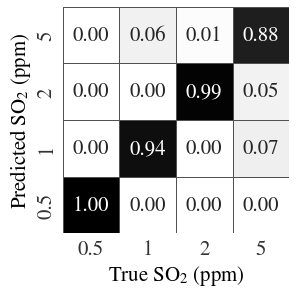

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
conf = confusion_matrix(yc_cnn_so2[0], yc_cnn_so2[1], normalize='pred')

conf = np.flipud(conf)
name = ['0.5', '1', '2', '5']

sn.heatmap(conf, annot=True, cmap="gray_r", square=True, vmax=1, vmin=0, fmt='0.2f',
           linewidths=.5, linecolor=COLOR[0], annot_kws={'fontsize': 20}, cbar=False)

ax.set_xlabel('True SO$_2$ (ppm)')
ax.set_ylabel('Predicted SO$_2$ (ppm)')
format_axis_im(ax)
plt.xticks(np.arange(0.5, 4, 1), name, horizontalalignment='center')
plt.yticks(np.arange(3.5, -0.5, -1), name, verticalalignment='center')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/conf_cnn_so2.png', dpi=300,
            bbox_inches='tight', transparent=True)


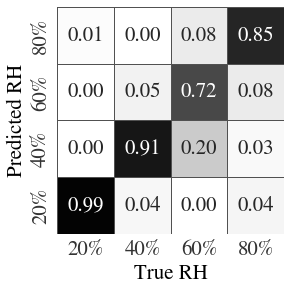

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
conf = confusion_matrix(yc_rh[0], yc_rh[1], normalize='pred')

conf = np.flipud(conf)
name = ['20%', '40%', '60%', '80%']

sn.heatmap(conf, annot=True, cmap="gray_r", square=True, vmax=1, vmin=0, fmt='0.2f',
           linewidths=.5, linecolor=COLOR[0], annot_kws={'fontsize': 20}, cbar=False)

ax.set_xlabel('True RH')
ax.set_ylabel('Predicted RH')
format_axis_im(ax)
plt.xticks(np.arange(0.5, 4, 1), name, horizontalalignment='center')
plt.yticks(np.arange(3.5, -0.5, -1), name, verticalalignment='center')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/conf_tda_rh.png', dpi=300,
            bbox_inches='tight', transparent=True)


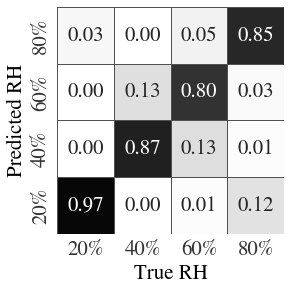

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
conf = confusion_matrix(yc_cnn_rh[0], yc_cnn_rh[1], normalize='pred')

conf = np.flipud(conf)
name = ['20%', '40%', '60%', '80%']

sn.heatmap(conf, annot=True, cmap="gray_r", square=True, vmax=1, vmin=0, fmt='0.2f',
           linewidths=.5, linecolor=COLOR[0], annot_kws={'fontsize': 20}, cbar=False)

ax.set_xlabel('True RH')
ax.set_ylabel('Predicted RH')
format_axis_im(ax)
plt.xticks(np.arange(0.5, 4, 1), name, horizontalalignment='center')
plt.yticks(np.arange(3.5, -0.5, -1), name, verticalalignment='center')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/conf_cnn_rh.png', dpi=300,
            bbox_inches='tight', transparent=True)


### 6. Regression Parity Plots
Corresponding to Figure 8.

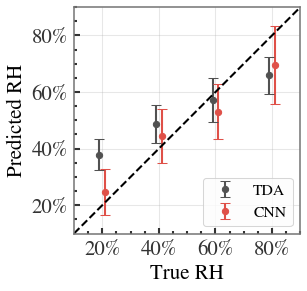

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
y_u = np.unique(yr_rh[0])
for i, y_ in enumerate(y_u):
    ind = np.where(yr_rh[0] == y_)[0]
    mean = yr_rh[1][ind].mean()
    std = yr_rh[1][ind].std()
    if i == 0:
        ax.errorbar(y_-0.01, mean, std,
                    color=COLOR[0], capsize=5, fmt='o', label='TDA')
    else:
        ax.errorbar(y_-0.01, mean, std, color=COLOR[0], capsize=5, fmt='o')

y_u = np.unique(yr_cnn_rh[0])
for i, y_ in enumerate(y_u):
    ind = np.where(yr_cnn_rh[0] == y_)[0]
    mean = yr_cnn_rh[1][ind].mean()
    std = yr_cnn_rh[1][ind].std()
    if i == 0:
        ax.errorbar(y_+0.01, mean, std,
                    color=COLOR[1], capsize=5, fmt='o', label='CNN')
    else:
        ax.errorbar(y_+0.01, mean, std, color=COLOR[1], capsize=5, fmt='o')
ax.plot([0.1, 0.9], [0.1, 0.9], 'k--')
ax.set_xlim([0.1, 0.9])
ax.set_ylim([0.1, 0.9])
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels(['20%', '40%', '60%', '80%'])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['20%', '40%', '60%', '80%'])
ax.set_xlabel('True RH')
ax.set_ylabel('Predicted RH')

ax.legend(loc=4)
format_axis(ax)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/parity_RH.png', dpi=300,
            bbox_inches='tight', transparent=True)


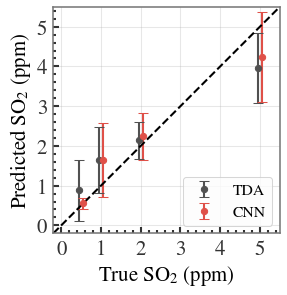

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
y_u = np.unique(yr_so2[0])
for i, y_ in enumerate(y_u):
    ind = np.where(yr_so2[0] == y_)[0]
    mean = yr_so2[1][ind].mean()
    std = yr_so2[1][ind].std()
    if i == 0:
        ax.errorbar(y_-0.05, mean, std,
                    color=COLOR[0], capsize=5, fmt='o', label='TDA')
    else:
        ax.errorbar(y_-0.05, mean, std, color=COLOR[0], capsize=5, fmt='o')

y_u = np.unique(yr_cnn_so2[0])
for i, y_ in enumerate(y_u):
    ind = np.where(yr_cnn_so2[0] == y_)[0]
    mean = yr_cnn_so2[1][ind].mean()
    std = yr_cnn_so2[1][ind].std()
    if i == 0:
        ax.errorbar(y_+0.05, mean, std,
                    color=COLOR[1], capsize=5, fmt='o', label='CNN')
    else:
        ax.errorbar(y_+0.05, mean, std, color=COLOR[1], capsize=5, fmt='o')

lim = [-0.2, 5.5]
ax.plot(lim, lim, 'k--')
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.set_xlabel('True SO$_2$ (ppm)')
ax.set_ylabel('Predicted SO$_2$ (ppm)')

ax.legend(loc=4)
format_axis(ax)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(np.arange(6))
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.arange(6))
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.savefig('../image/case_study_so2_rh/parity_SO2.png', dpi=300,
            bbox_inches='tight', transparent=True)
